# **XGBoost test**

This function handles evaluating XGBoost model performance, test one or more classifier models against held-out dataset<br>
Using held-out test features, evaluates the peformance of the estimated model.<br>
Can be part of a kubeflow pipeline as a test step that is run post EDA and training/validation cycles.<br>
To see how the model is trained or how the data-set is generated, check out `xgb_trainer` function from the function marketplace repository

### Steps
1. [Setup function parameters](#Setup-function-parameters)
2. [Importing the function](#Importing-the-function)
3. [Running the function locally](#Running-the-function-locally)
4. [Running the function remotely](#Running-the-function-remotely)

In [1]:
import warnings
warnings.filterwarnings("ignore")

### **Setup function parameters** 

In [2]:
task_params = {"name" : "tasks xgb test",
               "params": {"label_column"  : "labels",
                          "plots_dest"    : "plots/xgb_test"}}

### **Importing the function**

In [3]:
import mlrun
mlrun.set_environment(project='function-marketplace')

fn = mlrun.import_function('hub://xgb_test')
fn.apply(mlrun.auto_mount())
fn.image = "mlrun/ml-models"

> 2021-10-13 14:18:08,922 [info] loaded project function-marketplace from MLRun DB


### **Running the function locally**

> 2021-10-13 14:18:09,078 [info] starting run tasks_xgb_test uid=d7592180de3b40c7843748d8e85d4908 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...e85d4908,0,Oct 13 14:18:09,completed,tasks_xgb_test,v3io_user=danikind=owner=danihost=jupyter-dani-5bbd9959b7-tsgh8,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,accuracy=0.9632test-error=0.0368rocauc=0.984364949478981brier_score=0.03287091841943238f1-score=0.9624796084828712precision_score=0.9744013212221305recall_score=0.9508460918614021,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


> 2021-10-13 14:18:11,305 [info] run executed, status=completed


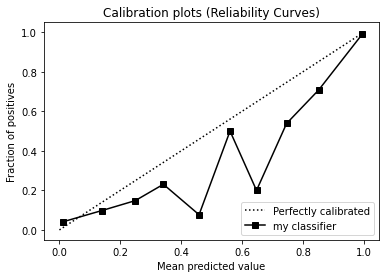

<Figure size 432x288 with 0 Axes>

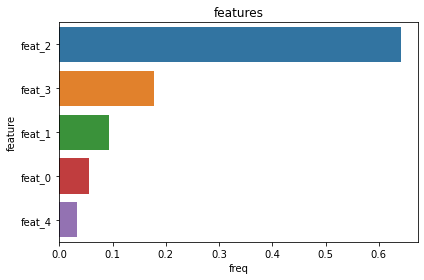

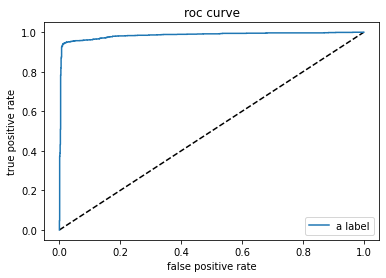

In [4]:
fn.run(name='tasks_xgb_test',
       params = {"label_column"  : "labels",
                 "plots_dest"    : "plots/xgb_test"},
       inputs = {"test_set"      : "https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_test/test_set.csv",
                 "models_path"   : "https://s3.wasabisys.com/iguazio/models/function-marketplace-models/xgb_test/xgb_model.pkl"},
       local=True)

### **Running the function remotely**

In [5]:
fn.deploy(with_mlrun=False, # mlrun is included in our image (mlrun/ml-models) therefore no mlrun installation is needed.
          skip_deployed=True) # because no new packages or upgrade is required, we can use the original image and not build another one.

fn.run(name='tasks_xgb_test',
       params = {"label_column"  : "labels",
                 "plots_dest"    : "plots/xgb_test"},
       inputs = {"test_set"      : "https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_test/test_set.csv",
                 "models_path"   : "https://s3.wasabisys.com/iguazio/models/function-marketplace-models/xgb_test/xgb_model.pkl"},
       local=False)

> 2021-10-13 14:18:11,731 [info] starting run tasks_xgb_test uid=0a00f5c7f9f044e4a500d1b9f1558780 DB=http://mlrun-api:8080
> 2021-10-13 14:18:11,920 [info] Job is running in the background, pod: tasks-xgb-test-l454w
> 2021-10-13 14:18:18,332 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...f1558780,0,Oct 13 14:18:17,completed,tasks_xgb_test,v3io_user=danikind=jobowner=danihost=tasks-xgb-test-l454w,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,accuracy=0.9632test-error=0.0368rocauc=0.984364949478981brier_score=0.03287091841943238f1-score=0.9624796084828712precision_score=0.9744013212221305recall_score=0.9508460918614021,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


> 2021-10-13 14:18:21,108 [info] run executed, status=completed


[Back to the top](#XGBoost-test)